In [1]:
%matplotlib inline
import os
from tqdm import tqdm
import sys
import os
file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(file_path))
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)

from Crunch.Models.layers import  *
from Crunch.Models.polynomials import  *
from Crunch.Auxiliary.metrics import  *
    
import time
import jax
from jax import lax
from jax import flatten_util
from jax import vmap
import jax.numpy as jnp
import optax

import argparse
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, vjp, value_and_grad,jit
from flax import linen as nn
from typing import Sequence
from functools import partial
import scipy
from pyDOE import lhs
import scipy.io as sio
from scipy.stats import wasserstein_distance

import jax
import jax.numpy as jnp
import random
import matplotlib as mpl


Project root: /oscar/data/gk/jdtoscan/PIML/Crunch_PIML


In [2]:
from jax import config
config.update("jax_default_matmul_precision", "float32")
# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [3]:
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

4


In [4]:
# Set up argument parser
parser = argparse.ArgumentParser(description='Tuning Parameters')
parser.add_argument('--Equation', type=str, default='vRBA_AC', help='Name of equation')
parser.add_argument('--Name', type=str, default='r2', help='Name of the experiment')
parser.add_argument('--NC', type=int, default=25600, help='Number of samples for training')
parser.add_argument('--NI', type=int, default=512, help='Number of iterations')
parser.add_argument('--NB', type=int, default=512, help='Batch size')
parser.add_argument('--NC_TEST', type=int, default=100, help='Number of test samples')
parser.add_argument('--SEED', type=int, default=444, help='Random seed')
parser.add_argument('--EPOCHS', type=int, default=300000, help='Number of training epochs')
parser.add_argument('--N_LAYERS', type=int, default=6, help='Number of layers in the network')
parser.add_argument('--HIDDEN', type=int, default=64, help='Number of hidden units per layer')
parser.add_argument('--FEATURES', type=int, default=1, help='Feature size')
parser.add_argument('--degree', type=int, default=5, help='Degree of outer')
parser.add_argument('--degree_T', type=int, default=5, help='Degree of polynomial')
parser.add_argument('--lr_fact', type=float, default=0.2, help='Scale Lr')
parser.add_argument('--eta', type=float, default=0.01, help='Learning rate or step size for adaptive gamma')
parser.add_argument('--gamma', type=float, default=0.999, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_grads', type=float, default=0.99, help='Decay rate for adaptive gamma')
parser.add_argument('--alpha', type=float, default=0.999750, help='Decay rate for exponential moving average')
parser.add_argument('--cap_RBA', type=float, default=20, help='Cap limit for RBA')
parser.add_argument('--max_RBA', type=float, help='Maximum RBA value, default calculated as eta / (1 - gamma)')
parser.add_argument('--decay_rate', type=float, default=0.9, help='Decay rate for learning rate schedule')
parser.add_argument('--LR', type=float, default=1e-3, help='Initial learning rate')
parser.add_argument('--decay_step', type=int,default=5000, help='Decay step size')
parser.add_argument('--Note', type=str, default='', help='In case')
parser.add_argument('--batch_size', type=int, default=10000, help='batch_size')
parser.add_argument('--k_samp', type=float, default=0.0, help='Enhance outliers smoothing factor')
parser.add_argument('--c_samp', type=float, default=1.0, help='homogenize')
parser.add_argument('--phi', type=float, default=0.9, help='Enhance outliers smoothing factor')
parser.add_argument('--c_log', type=float, default=1.0, help='homogenize')

# Parse arguments and display them
args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

# Initialize parameters with parsed or default values
NC = args.NC
NI = args.NI
NB = args.NB
NC_TEST = args.NC_TEST
SEED = args.SEED
EPOCHS = args.EPOCHS
N_LAYERS = args.N_LAYERS
HIDDEN = args.HIDDEN
FEATURES = args.FEATURES
degree = args.degree
degree_T = args.degree_T
eta = args.eta
#RBA Params
gamma = args.gamma
alpha = args.alpha
max_RBA0 = args.max_RBA if args.max_RBA is not None else eta / (1 - gamma)
cap_RBA = args.cap_RBA
# Global weights
gamma_grads=args.gamma_grads
#RBA-R
k_samp=args.k_samp
c_samp=args.c_samp
batch_size=args.batch_size
#vRBA
c_log=args.c_log
phi=args.phi

# Optimizer parameters
decay_rate = args.decay_rate
LR = args.LR
lr0 = LR
decay_step = args.decay_step# if args.decay_step is not None else int(EPOCHS * jnp.log(decay_rate) / jnp.log(lrf / lr0))
args.Name=args.Name+f'vRBA-phi:{phi:.2f}-c_log:{c_log:.2f}-bs:{batch_size}_Seed:{SEED}'+args.Note
print(args.Name)
# random key
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
# Initialize NumPy seed
np.random.seed(SEED)
# Initialize Python's random module seed
random.seed(SEED)


Equation: vRBA_AC
Name: r2
NC: 25600
NI: 512
NB: 512
NC_TEST: 100
SEED: 444
EPOCHS: 300000
N_LAYERS: 6
HIDDEN: 64
FEATURES: 1
degree: 5
degree_T: 5
lr_fact: 0.2
eta: 0.01
gamma: 0.999
gamma_grads: 0.99
alpha: 0.99975
cap_RBA: 20
max_RBA: None
decay_rate: 0.9
LR: 0.001
decay_step: 5000
Note: 
batch_size: 10000
k_samp: 0.0
c_samp: 1.0
phi: 0.9
c_log: 1.0
r2vRBA-phi:0.90-c_log:1.00-bs:10000_Seed:444


## Auxiliary Functions


In [5]:
def get_gamma(eta, max_RBA):
    gamma_it = 1-eta/max_RBA
    return gamma_it

@partial(jax.jit, static_argnames=("batch_size", "k", "c"))
def sample_points_pdf(e, batch_size, lambdas, tc, xc, ti, xi, ui, xb1, x, t, u_gt, k=1, c=0.5):
    key = jax.random.PRNGKey(e)
    
    lambdas_k = lambdas**k
    lambdas_k = lambdas_k / lambdas_k.mean() + c
    lambdas_k = lambdas_k.flatten()
    p = lambdas_k / lambdas_k.sum()

    idx_train = jax.random.choice(key, len(lambdas), shape=(batch_size,), p=p)
    
    # Now all variables are properly passed as arguments
    train_data = tc[idx_train], xc[idx_train], ti, xi, ui, xb1, x, t, u_gt
    return idx_train, train_data

# Geometric complexity
def get_g_x(params, t, x):
    # Compute u
    u = apply_fn(params, t, x)
    # Compute derivatives
    v_t = jnp.ones_like(t)
    v_x = jnp.ones_like(x)
    u_t = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
    u_x = jvp(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))[1]
    return jnp.hstack([u_t,u_x])
def get_GC(params,t,x):
    g_x=get_g_x(params, t, x)[:,:,None]
    norm_f_tx = jnp.linalg.norm(g_x, ord='fro', axis=(1, 2))**2
    model_gc=jnp.mean(norm_f_tx)
    return model_gc

## 1. PINN

In [6]:
class MLP(nn.Module):
    degree: int
    features: Sequence[int]
    M:int =10
    @nn.compact
    def __call__(self, t, x):
        init = nn.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="uniform")
        X = Fourier_Embedding(degree=self.M)(x) 
        X = jnp.concatenate([t, X], axis=-1)
        H = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
        for fs in self.features[1:-1]:
            H = nn.activation.tanh(nn.Dense(fs, kernel_init=init)(H))
        H = nn.Dense(self.features[-1], kernel_init=init)(H)
        return H

# forward function
class PINN(nn.Module):
    degree: int
    degree_T:int
    features: Sequence[int]
    M:int =10
    def setup(self):
         self.MLP = MLP(degree=self.degree,features=self.features,M=self.M)
    @nn.compact
    def __call__(self, t, x):
        H=self.MLP(t,x)
        return H
# optimizer step function
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

In [7]:
@partial(jax.jit, static_argnums=(0, 1))  # key and optimizer are static
def update_model(key, optimizer, gradient, params, state):
    # Perform updates using the specified optimizer and key
    updates, new_state = optimizer.update(gradient['params'][key], state)
    new_params = optax.apply_updates(params['params'][key], updates)
    # Return updated parameters and state for this key only
    params['params'][key] = new_params
    return params, new_state


In [8]:
@partial(jax.jit, static_argnums=(0,))
def apply_model(apply_fn, params, lambdas, gamma, eta,lamE,lamB,all_grads,idx_train,it, *train_data):
    # Unpack data
    t, x, ti, xi, ui, xb1, xb2, tb, ub = train_data
    lambdas_it = jnp.take(lambdas, idx_train, axis=0)

    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))
        # Compute residuals using u, ut, and uxx
        return ut - 0.0001 * uxx + 5.0 * u ** 3 - 5.0 * u

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        q_it=r_i/r_i.max()
        new_lambdas = gamma * lambdas + eta*q_it
        # Compute residual loss using updated lambdas
        pde_loss = jnp.mean((new_lambdas*residuals)**2)
        return pde_loss, new_lambdas

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    # Compute gradients separately
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas_it)
    ics_loss, gradient_bcs = jax.value_and_grad(loss_bcs)(params)
    # Update lambdas
    lambdas = lambdas.at[idx_train].set(new_lambdas)
    # Flatten the gradients and compute L2 norms
    pde_gradient_flat, _ = flatten_util.ravel_pytree(gradient_pde)
    bcs_gradient_flat, _ = flatten_util.ravel_pytree(gradient_bcs)

    grad_PDE_norm= jnp.linalg.norm(pde_gradient_flat)+1e-7
    grad_bcs_norm = jnp.linalg.norm(bcs_gradient_flat)+1e-7
    # Grads_average
    grad_avg_PDE=gamma_grads*all_grads['grad_bar_PDE']+(1-gamma_grads)*grad_PDE_norm
    grad_avg_BCs=gamma_grads*all_grads['grad_bar_BCs']+(1-gamma_grads)*grad_bcs_norm
    #Update weights
    lamB=alpha*lamB+(1-alpha)*grad_avg_PDE/grad_avg_BCs

    # Combine loss and gradients
    total_gradient = jax.tree_util.tree_map(lambda g_pde, g_bcs: lamE * g_pde + lamB * g_bcs, gradient_pde, gradient_bcs)
    #Store
    all_loss={
        'loss_PDE':pde_loss,
        'loss_BCs':ics_loss,
        'Loss':lamE * pde_loss + lamB * ics_loss,
    }
    all_grads={
        'grad_bar_PDE':grad_avg_PDE,
        'grad_bar_BCs':grad_avg_BCs,
        'grad_PDE':grad_PDE_norm,
        'grad_BCs':grad_bcs_norm,
    }
    return all_loss, total_gradient, lambdas,lamB,all_grads

# Compute Metrics

In [9]:
@partial(jax.jit, static_argnums=(0,))
def get_residuals(apply_fn, params, lambdas, gamma, eta,lamE,lamB, *train_data):
    # Unpack data
    t, x, ti, xi, ui, xb1, xb2, tb, ub = train_data
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))
        # Compute residuals using u, ut, and uxx
        return ut - 0.0001 * uxx + 5.0 * u ** 3 - 5.0 * u

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        return residuals**2

    # Compute residuals
    residuals=loss_pde(params, lambdas)
    return  residuals

In [10]:
@partial(jax.jit, static_argnums=(0,))
def get_gradient(apply_fn, params, lambdas, gamma, eta,lamE,lamB, *train_data):
    # Unpack data
    t, x, ti, xi, ui = train_data
    
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))
        # Compute residuals using u, ut, and uxx
        return ut - 0.0001 * uxx + 5.0 * u ** 3 - 5.0 * u

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        # Compute residual loss using updated lambdas
        pde_loss = jnp.mean(( residuals) ** 2)
        return pde_loss, lambdas

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    # Compute gradients separately
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas)
    ics_loss, gradient_bcs = jax.value_and_grad(loss_bcs)(params)

    # Combine loss and gradients
    total_gradient = jax.tree_util.tree_map(lambda g_pde, g_bcs: lamE * g_pde + lamB * g_bcs, gradient_pde, gradient_bcs)
    gradient_flat_inner, _ = flatten_util.ravel_pytree(total_gradient)#['params']['get_Psi'])
    #gradient_flat_outer, _ = flatten_util.ravel_pytree(total_gradient['params']['RBF_KAN_layer_0'])
    return  gradient_flat_inner/(jnp.linalg.norm(gradient_flat_inner)+1e-20),0.0#,gradient_flat_outer/(jnp.linalg.norm(gradient_flat_outer)+1e-10)

In [11]:
def KL_divergence(p, q):
    term1 = jax.scipy.special.xlogy(p, p)
    term2 = jax.scipy.special.xlogy(p, q)
    return jnp.sum(term1 - term2)

def get_pdf(u_hist, bins=100):
    hist_densities, bin_edges = jnp.histogram(u_hist, bins=bins, density=True)
    bin_widths = jnp.diff(bin_edges)
    prob_density_corrected = hist_densities* bin_widths
    return prob_density_corrected, bin_edges

# Step 1: Add all required data arrays to the function signature
def get_metrics(e, apply_fn, params, lambdas, gamma_it, eta, lamE, lamB, tc, xc, ti, xi, ui, xb1, x, t, u_gt, N_batches=50):
    Var = {}
    distance = {}
    
    # Assemble the full data tuple once
    full_data = (tc, xc, ti, xi, ui, xb1, x, t, u_gt)

    # p variance
    all_res = []
    for batch_n in range(N_batches):
        idx_train, train_data_batch = sample_points_pdf(e + batch_n, batch_size, lambdas, *full_data, k=0.0, c=1.0)
        residuals = get_residuals(apply_fn, params, lambdas, gamma_it, eta, lamE, lamB, *train_data_batch)
        all_res.append(residuals.flatten())
    
    all_res_p = jnp.vstack(all_res)
    Var['p'] = jnp.std(all_res_p)**2
    p_res = jnp.ones_like(lambdas.flatten()) / lambdas.size

    # q variance
    all_res = []
    for batch_n in range(N_batches):
        idx_train, train_data_batch = sample_points_pdf(e + batch_n, batch_size, lambdas, *full_data, k=1.0, c=0.0)
        residuals = get_residuals(apply_fn, params, lambdas, gamma_it, eta, lamE, lamB, *train_data_batch) 
        all_res.append(residuals.flatten())

    all_res_q = jnp.vstack(all_res)
    Var['q'] = jnp.std(all_res_q)**2
    q_res = (lambdas.flatten() + 1e-20)
    q_res = q_res / q_res.sum()
    
    distance['wd'] = wasserstein_distance(p_res, q_res)
    distance['KL'] = KL_divergence(p_res, q_res)
    
    return Var, distance



In [12]:
def get_SRN(apply_fn,params, lambdas,gamma_it,eta,lamE,lamB,X_batches):    
    all_gradients={
        'inner':[],
        #'outer':[],
    }
    for X_batch in X_batches:
        #Select data
        train_data_batch=X_batch[:,0:1],X_batch[:,1:2],ti,xi,ui
        # Get Gradient
        gradient_flat_inner,gradient_flat_outer=get_gradient(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB, *train_data_batch)
        all_gradients['inner'].append(gradient_flat_inner)
        #all_gradients['outer'].append(gradient_flat_inner)
    grad_SNR={}
    for key in all_gradients.keys():
        array_grad=jnp.array(all_gradients[key])
        mean_grad=jnp.mean(array_grad,axis=0)
        std_grad=jnp.std(array_grad,axis=0)
        norm_mean_grad=jnp.linalg.norm(mean_grad)
        norm_std_grad=jnp.linalg.norm(std_grad)
        grad_SNR[key]=np.array(norm_mean_grad/norm_std_grad)
    return grad_SNR


In [13]:
def get_g_x(params, t, x):
    # Compute u
    u = apply_fn(params, t, x)
    # Compute derivatives
    v_t = jnp.ones_like(t)
    v_x = jnp.ones_like(x)
    u_t = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
    u_x = jvp(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))[1]
    return jnp.hstack([u_t,u_x])


In [14]:
@jit
def get_GC(params,t,x):
    g_x=get_g_x(params, t, x)[:,:,None]
    norm_f_tx = jnp.linalg.norm(g_x, ord='fro', axis=(1, 2))**2
    model_gc=jnp.mean(norm_f_tx)
    return model_gc


# Load Data

In [15]:
data = scipy.io.loadmat('../Data/allen_cahn_HR.mat')
Exact = data['usol'].T
Exact0 = np.real(Exact)
t0 = data['t']
t0= t0.flatten()[:,None]
x0 = data['x'][:,:]
x0=x0.flatten()[:,None]
T, X = np.meshgrid(t0, x0) 
# Ground Truth
t=T.flatten()[:,None]
x=X.flatten()[:,None]
u_gt=Exact0.flatten()[:,None]
# Collocation points
lb_D = jnp.array([ t0.min(),x0.min()])
ub_D = jnp.array([ t0.max(),x0.max()])
print(lb_D)
print(ub_D)

X_c= lb_D + (ub_D-lb_D)*lhs(2, NC)
tc=X_c[:,0:1]
xc=X_c[:,1:2]
# Initial conditions
keys = jax.random.split(key, 13)
ti = T[:,0:1]
xi = X[:,0:1]
ui = Exact0[:,0:1]
# Boundary Conditions
tb=jax.random.uniform(keys[3], (NB, 1), minval=lb_D[0], maxval=ub_D[0])
xb1=tb*0-1
xb2=tb*0+1
ub=xb1*0-1
train_data=tc,xc,ti,xi,ui,xb1,x,t,u_gt
lambdas=tc*0+0.0


[ 0. -1.]
[1. 1.]


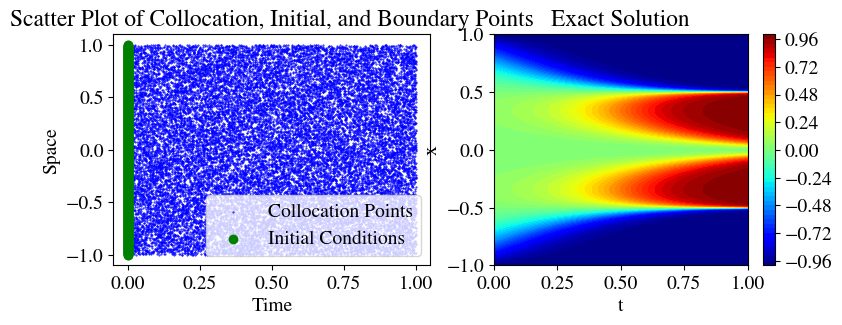

In [16]:
# Plotting code
fig = plt.figure(figsize=(9, 3))

# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(121)
ax1.scatter(tc, xc, color='blue', label='Collocation Points',s=0.2)
ax1.scatter(ti, xi, color='green', label='Initial Conditions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Space')
ax1.set_title('Scatter Plot of Collocation, Initial, and Boundary Points')
ax1.legend()

# Surface plot for Exact solution
ax2 = fig.add_subplot(122)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=50)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Exact Solution')
plt.show()

In [17]:
# Batches SNR
n_batches=100
X_c2= lb_D + (ub_D-lb_D)*lhs(2, 2*NC)
X_batches=np.array(np.split(X_c2,n_batches))
X_batches.shape

(100, 512, 2)

## Initialize Model

In [18]:
# feature sizes
feat_sizes = tuple([HIDDEN for _ in range(N_LAYERS)] + [FEATURES])
print(feat_sizes)
# make & init model
model = PINN(degree=degree,degree_T=degree_T,features=feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)))

optimizers = {}
for key in params['params'].keys():
    if key=='g_fx':
        print('KART layer')
        optimizers[key]=optax.adam(optax.exponential_decay(lr0*args.lr_fact, decay_step, decay_rate, staircase=False))
    else:
        optimizers[key]=optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate, staircase=False))


# Initialize optimizer states for each parameter group
states = {key: optim.init(params['params'][key]) for key, optim in optimizers.items()}

# forward & loss function
apply_fn = jax.jit(model.apply)


total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(total_params )

(64, 64, 64, 64, 64, 64, 1)
22337


In [19]:
print(get_GC(params,t,x))

31.868834


# Training

In [20]:
all_errors = []
all_its = []
all_loss = []
all_gamma = []
all_lamB = []
all_max_RBA = []
all_SNR_psi = []
all_SNR_g = []
all_lamE = []
all_lambdas=[]
all_idx=[]
all_Var_p = []
all_Var_q = []
all_d= []
all_KL= []
all_gc = []



start = time.time()
pbar = tqdm(range(1, EPOCHS + 1), desc='Training Progress')
gamma_it=get_gamma(eta, max_RBA0)
#Global weights
max_RBA=max_RBA0
lamE,lamB=1,max_RBA**2
#RBA
step_RBA=(cap_RBA-max_RBA0)/(EPOCHS/50000-1)
# initialize grads container
all_grads={
    'grad_bar_PDE':1,
    'grad_bar_BCs':1,
}
for e in pbar:
    # sample batch 
    train_data_full = (tc, xc, ti, xi, ui, xb1, x, t, u_gt)
    idx_train, train_data_batch = sample_points_pdf(e, batch_size, lambdas, *train_data_full, k=k_samp, c=c_samp)
     # single run
    all_loss_it, gradient, lambdas,lamB,all_grads = apply_model(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB,all_grads,idx_train,e, *train_data_batch)

    for key in params['params']:
        params, states[key] = update_model(key, optimizers[key], gradient, params, states[key])
    log_frequency = 1 if e < 500 else 100 if e <= 5000 else 500
    if e % log_frequency == 0:
        #Compute SNR
        grad_SNR=get_SRN(apply_fn,params, lambdas,gamma_it,eta,lamE,lamB,X_batches)
        #Compute variance
        full_data_tuple = (tc, xc, ti, xi, ui, xb1, x, t, u_gt)
        Var, distance = get_metrics(e, apply_fn, params, lambdas, gamma_it, eta, lamE, lamB, *full_data_tuple)        
        # Update RBA
        max_RBA=max_RBA0+step_RBA*e//50000
        gamma_it=get_gamma(eta, max_RBA)
        all_lambdas.append(np.array(lambdas))  # JAX to NumPy conversion
        all_idx.append(idx_train)
        #Compute errors
        error = relative_l2(apply_fn(params, t, x), u_gt)
        # Geometric Complexity
        model_gc=get_GC(params,t,x)
        # Updating the tqdm progress bar with loss and other metrics
        pbar.set_description(f"It: {e}/{EPOCHS} | Error: {error:.3e} | lam_max: {lambdas.max():.3f}| max_RBA: {max_RBA:.3f}| lamB: {lamB:.3f}|gc:{model_gc:.3f}")       
        # Append metrics to lists
        all_Var_q.append(Var['q'])
        all_Var_p.append(Var['p'])
        all_d.append(distance['wd'])
        all_KL.append(distance['KL'])
        all_SNR_psi.append(grad_SNR['inner'])
        #all_SNR_g.append(grad_SNR['outer'])
        all_errors.append(error)
        all_its.append(e)
        all_lambdas.append(np.array(lambdas))
        all_loss.append(all_loss_it['Loss'])
        all_gamma.append(gamma_it)
        all_lamB.append(lamB)
        all_max_RBA.append(lambdas.max())
        all_lamE.append(lamE)
        all_gc.append(model_gc)
end = time.time()
print(f'Runtime: {((end - start) / EPOCHS * 1000):.2f} ms/iter.')

It: 300000/300000 | Error: 4.143e-04 | lam_max: 20.311| max_RBA: 22.000| lamB: 1145.347|gc:27.976: 100%|██████████| 300000/300000 [23:42<00:00, 210.94it/s]

Runtime: 4.74 ms/iter.


# Save Results

In [21]:
results_dict = {
    'model_name': args.Name,
    'all_errors': all_errors,
    'all_its': all_its,
    'all_Var_q': all_Var_q,
    'all_Var_p': all_Var_p,
    'all_d': all_d,
    'all_KL': all_KL,
    'all_loss': all_loss,
    'all_gamma': all_gamma,
    'all_lamB': all_lamB,
    'all_max_RBA': all_max_RBA,
    'all_SNR_psi': all_SNR_psi,
    'all_SNR_g': all_SNR_g,
}

# Save dictionary as a .mat file
scipy.io.savemat(args.Name + 'Log_files.mat', results_dict)

# Errors


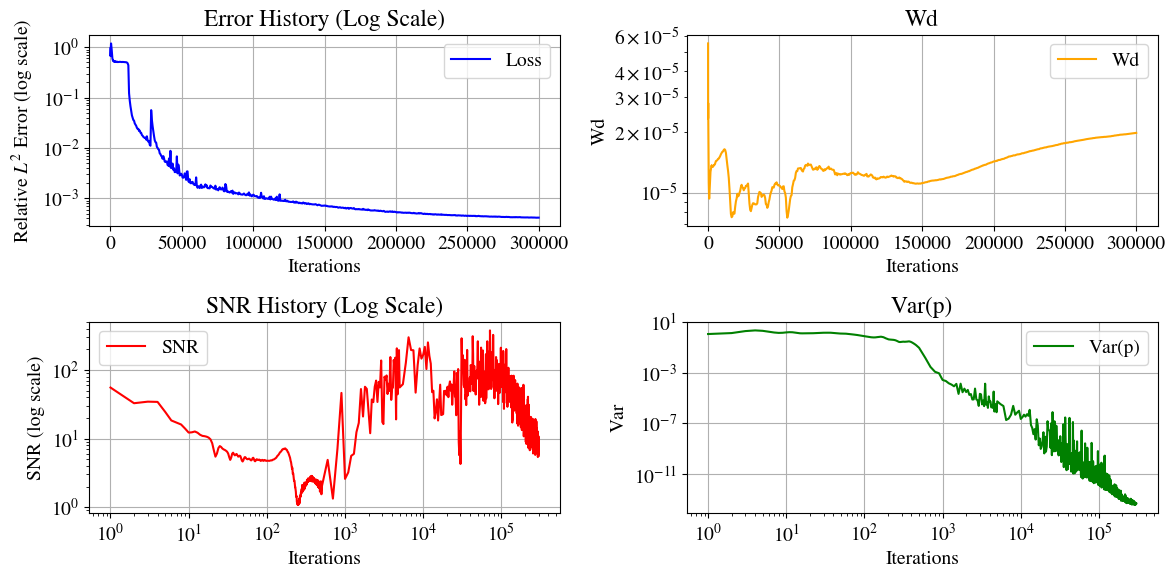

In [22]:
# Adjusting the plot to use a log scale for both loss and error

plt.figure(figsize=(12, 6))
# Plotting loss history with log scale
plt.subplot(2, 2, 1)
plt.plot(all_its, all_errors, label='Loss', color='blue')
plt.yscale('log')

#plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative $L^2$ Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 3)
plt.plot(all_its, all_SNR_psi, label='SNR', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('SNR (log scale)')
plt.title('SNR History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 2)
plt.plot(all_its, all_d, label='Wd', color='orange')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Wd')
plt.title('Wd')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(all_its, all_Var_p, label='Var(p)', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Var')
plt.title('Var(p)')
plt.grid(True)
plt.legend()


# Show the plots
plt.tight_layout()
plt.savefig(args.Name+'_Loss.png')
plt.show()


In [23]:
error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 

RL2 error: 0.00041430


# Visualization

Solution:


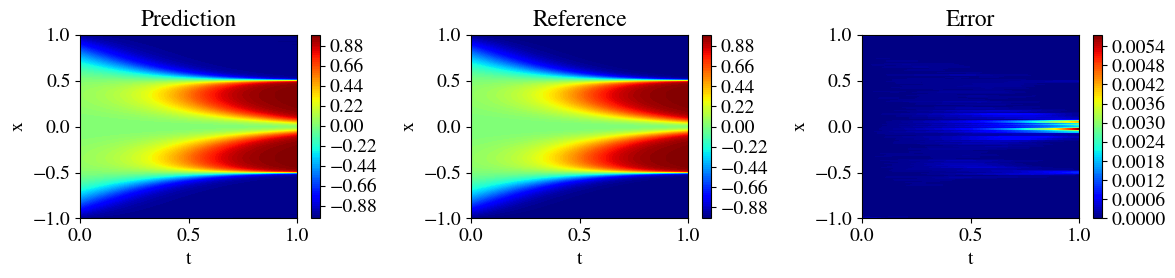

In [24]:
it=-1
print('Solution:')
u = apply_fn(params, t, x)
u = u.reshape(T.shape)
lambdas_grid=all_lambdas[it]
idx_it=all_idx[it]

# Plotting code
fig = plt.figure(figsize=(12, 3))
levels=100
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(131)
contour = ax1.contourf(T, X, u, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Surface plot for Exact solution
ax2 = fig.add_subplot(132)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')
# Surface plot for Exact solution
ax3 = fig.add_subplot(133)
contour = ax3.contourf(T, X, np.abs(Exact0-u), cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')
plt.tight_layout()

plt.savefig(args.Name+'Errorss_RBA-R.png',dpi=300)
plt.show()

Solution:


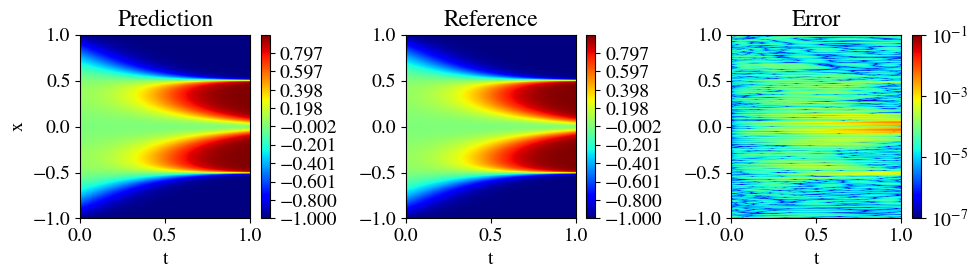

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

it=-1
print('Solution:')

# --- 1. Find the global vmin and vmax across BOTH datasets ---
global_vmin = np.min([u, Exact0])
global_vmax = np.max([u, Exact0])

# --- 2. Create a shared array of contour levels ---
# This is the key change that guarantees the colorbars are identical.
num_levels = 500
shared_levels = np.linspace(global_vmin, global_vmax, num_levels)


# Plotting code
fig = plt.figure(figsize=(10, 3))

# --- Plot for Prediction (using the shared levels array) ---
ax1 = fig.add_subplot(131)
contour1 = ax1.contourf(T, X, u, cmap='jet', 
                        levels=shared_levels) # <-- Use the shared levels array
fig.colorbar(contour1, ax=ax1)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# --- Plot for Reference Solution (using the shared levels array) ---
ax2 = fig.add_subplot(132)
contour2 = ax2.contourf(T, X, Exact0, cmap='jet', 
                        levels=shared_levels) # <-- Use the shared levels array
fig.colorbar(contour2, ax=ax2)
ax2.set_xlabel('t')
#ax2.set_ylabel('x')
ax2.set_title('Reference')

# --- Plot for Error (this part is separate and correct) ---
ax3 = fig.add_subplot(133)
error_data = np.abs(Exact0-u)
log_norm = colors.LogNorm(vmin=1e-7, vmax=1e-1)

mesh3 = ax3.pcolormesh(T, X, error_data, 
                       cmap='jet', 
                       norm=log_norm,
                       shading='gouraud')

fig.colorbar(mesh3, ax=ax3)
ax3.set_xlabel('t')
#ax3.set_ylabel('x')
ax3.set_title('Error')

plt.tight_layout()
plt.savefig(args.Name+'Errors_RBA_AC.png',dpi=300)
plt.show()